# Dataset : https://www.kaggle.com/datasets/andrewmvd/animal-faces

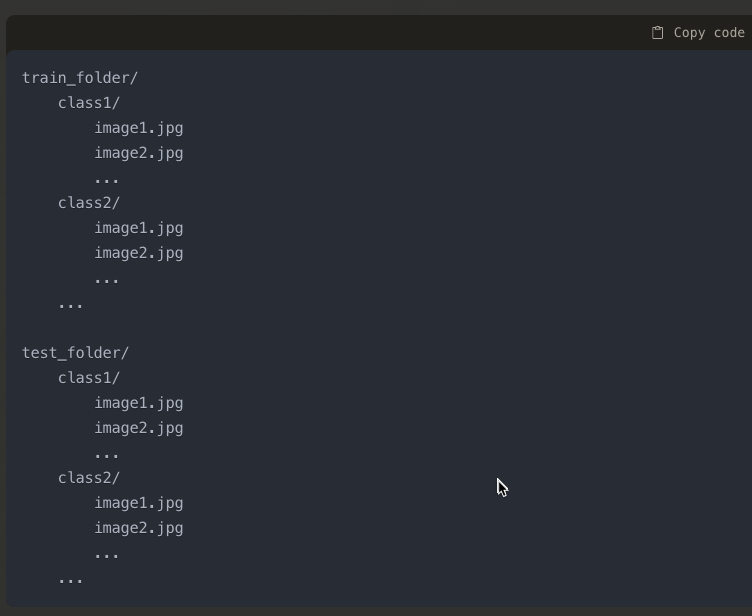

In [8]:
!nvidia-smi -L


GPU 0: NVIDIA A100-SXM4-80GB (UUID: GPU-6620e1a6-0d7f-6cfe-1290-c3b795ee422b)
  MIG 1g.10gb     Device  0: (UUID: MIG-23c4e088-ce35-5324-afdf-34f3960bcdb0)
  MIG 1g.10gb     Device  1: (UUID: MIG-a40ffb87-88e6-5f6f-bde7-1af6ad01adf2)
  MIG 1g.10gb     Device  2: (UUID: MIG-fccb8438-5870-52c3-aafa-42fddedd6b8e)
  MIG 1g.10gb     Device  3: (UUID: MIG-8e6a7989-84f7-53a8-ac83-762afe1fbd36)
  MIG 1g.10gb     Device  4: (UUID: MIG-b71e4b1a-a7c6-55b2-bdee-ddfc11df3f60)
  MIG 1g.10gb     Device  5: (UUID: MIG-1f8b2754-cb9d-509f-b2dc-c4ff99a35290)
  MIG 1g.10gb     Device  6: (UUID: MIG-f7abf2c0-a5f2-5ca3-b7cb-215c92d6e9c9)
GPU 1: NVIDIA A100-SXM4-80GB (UUID: GPU-e84e0c4d-caeb-bff4-5bc2-79000e81f2c0)
  MIG 1g.10gb     Device  0: (UUID: MIG-65568ef3-874c-554e-8033-47d7eda53db5)
  MIG 1g.10gb     Device  1: (UUID: MIG-f31fdd03-d04b-53cb-b889-3c53ba7e4c29)
  MIG 1g.10gb     Device  2: (UUID: MIG-e76da236-a0d8-513c-9b81-253e7b9bda25)
  MIG 1g.10gb     Device  3: (UUID: MIG-248dba60-a9de-5218-81ae-

# Install 

In [9]:
from IPython.display import clear_output

!pip install -q transformers datasets evaluate accelerate
!pip install kaggle

clear_output()

# We encourage you to log in to your Hugging Face account to upload and share your model with the community. When prompted, enter your token to log in:

In [10]:

from huggingface_hub import notebook_login
notebook_login()


# from huggingface_hub import login
# login(token="")



In [11]:
import os
import json

kaggle_json_path = "/home/tuchsanai/Github/DL-FOR-COMPUTER-VISION/kaggle.json"

try :
    # Read the kaggle.json file
    with open(kaggle_json_path) as f:
       kaggle_config = json.load(f)

    userkaggle       = kaggle_config['username']
    passkaggle       = kaggle_config['key']
    os.environ['KAGGLE_USERNAME'] = userkaggle
    os.environ['KAGGLE_KEY'] = passkaggle
    print("KAGGLE_USERNAME and KAGGLE_KEY are set.")
except :
    print("KAGGLE_USERNAME or KAGGLE_KEY is not set.")

KAGGLE_USERNAME and KAGGLE_KEY are set.


In [12]:
import zipfile
import os
from IPython.display import clear_output


# Specify the desired download path
download_path = "/raid/scratch/tuchsanai/"

dataset_name = 'animal-faces'
zip_path = f'{dataset_name}.zip'


# Create the download directory if it doesn't exist
os.makedirs(download_path, exist_ok=True)

# Download the dataset to the specified path
if not os.path.exists(os.path.join(download_path, dataset_name)):
    !kaggle datasets download -d andrewmvd/animal-faces -p {download_path}

# Extract the downloaded zip file to the specified path
if not os.path.exists(os.path.join(download_path, dataset_name)) and os.path.exists(os.path.join(download_path, zip_path)):
    with zipfile.ZipFile(os.path.join(download_path, zip_path), 'r') as zip_ref:
        zip_ref.extractall(os.path.join(download_path, dataset_name))

In [13]:
from datasets import load_dataset
from transformers import AutoImageProcessor, AutoModelForImageClassification

from transformers import TrainingArguments, Trainer
from torchvision import transforms
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, RandomHorizontalFlip, RandomResizedCrop, RandomRotation
    

# Specify the desired download path
download_path = "/raid/scratch/tuchsanai/"

# Define the paths to your train and test folders
dataset_folder = download_path +"/animal-faces/afhq/train"



# Create the train dataset

dataset = load_dataset("imagefolder", data_dir=dataset_folder, split="train")

# Split the dataset into train and test sets
train_test_dataset = dataset.train_test_split(test_size=0.2, seed=42)



# option 1:  note that you can also provide several splits:
# dataset = load_dataset("imagefolder", data_files={"train": ["path/to/file1", "path/to/file2"], "test": ["path/to/file3", "path/to/file4"]})


 #option 2: local folder
# dataset = load_dataset("imagefolder", data_dir="path_to_folder")


# note that you can push your dataset to the hub very easily (and reload afterwards using load_dataset)!
# dataset.push_to_hub("tp/eurosat")
# dataset.push_to_hub("tp/eurosat", private=True)

#
#

Resolving data files:   0%|          | 0/14630 [00:00<?, ?it/s]

In [14]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 14630
})

In [15]:
train_test_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 11704
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2926
    })
})

### To make it easier for the model to get the label name from the label id, create a dictionary that maps the label name to an integer and vice versa:

In [16]:
labels = train_test_dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label


print(label2id)
print(id2label)
print(labels)

{'cat': 0, 'dog': 1, 'wild': 2}
{0: 'cat', 1: 'dog', 2: 'wild'}
['cat', 'dog', 'wild']


In [17]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
from transformers import TrainingArguments, Trainer
from torchvision import transforms
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, RandomHorizontalFlip, RandomResizedCrop, RandomRotation


# Define the image transformations for data augmentation

train_transforms = Compose(
    [
        RandomResizedCrop(224),
        RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomRotation(degrees=50),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transforms = Compose(
    [
        Resize(256),
        CenterCrop(224),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


def train_transforms_fn(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [train_transforms( image.convert("RGB")) for image in example_batch["image"] ]
    return example_batch

def val_transforms_fn(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms( image.convert("RGB")) for image in example_batch["image"] ]
    return example_batch




In [18]:
#train_dataset = train_test_dataset["train"].map(train_transforms_fn, batched=True)
#test_dataset = train_test_dataset["test"].map(val_transforms_fn, batched=True)

train_dataset = train_test_dataset["train"].with_transform(train_transforms_fn).shuffle(seed=42).select(range(1000))
test_dataset = train_test_dataset["test"].with_transform(val_transforms_fn).shuffle(seed=42)


In [19]:
train_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 1000
})

In [20]:
test_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 2926
})

# Preprocess


In [21]:
from transformers import AutoImageProcessor

model_checkpoint = checkpoint = "google/vit-base-patch16-224-in21k"


image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor 

ViTImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [22]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)


model

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [23]:
import evaluate

accuracy = evaluate.load("accuracy")

In [24]:
import numpy as np
import torch


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)



def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [25]:
import time
import torch
from transformers import TrainerCallback

class GPUMonitoringCallback(TrainerCallback):
    def on_train_begin(self, args, state, control, **kwargs):
        self.start_time = time.time()

    def on_step_begin(self, args, state, control, **kwargs):
        if torch.cuda.is_available():
            gpu_memory_allocated = torch.cuda.memory_allocated()
            gpu_memory_reserved = torch.cuda.memory_reserved()
            gpu_memory_total = torch.cuda.get_device_properties(0).total_memory
            gpu_memory_usage = (gpu_memory_allocated + gpu_memory_reserved) / gpu_memory_total * 100
            gpu_memory_usage_gb = (gpu_memory_allocated + gpu_memory_reserved) / (1024 * 1024 * 1024)  # Convert to GB
            
            elapsed_time = time.time() - self.start_time
            hours, remainder = divmod(elapsed_time, 3600)
            minutes, seconds = divmod(remainder, 60)
            
            print(f"\rStep: {state.global_step}, GPU Memory Usage: {gpu_memory_usage_gb:.2f} GB ({gpu_memory_usage:.2f}%), Elapsed Time: {int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}", end="", flush=True)

    def on_train_end(self, args, state, control, **kwargs):
        total_time = time.time() - self.start_time
        hours, remainder = divmod(total_time, 3600)
        minutes, seconds = divmod(remainder, 60)
        print(f"\nTotal Training Time: {int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}")

# Create an instance of the GPUMonitoringCallback
gpu_monitoring_callback = GPUMonitoringCallback()




In [26]:

training_args = TrainingArguments(
    output_dir="my_awesome_food_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    gradient_accumulation_steps=1,
    per_device_eval_batch_size=32,
    num_train_epochs=8,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
   # push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[gpu_monitoring_callback],
)

trainer.train()

/home/tuchsanai/.conda/envs/torch/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step: 0, GPU Memory Usage: 0.77 GB (0.97%), Elapsed Time: 00:00:01

Epoch,Training Loss,Validation Loss,Accuracy
1,1.085000,0.965439,0.820232
2,0.826300,0.744217,0.973684
3,0.704500,0.562254,0.987697
4,0.482000,0.431894,0.992481
5,0.351400,0.348045,0.993506
6,0.314100,0.302747,0.993165
7,0.272300,0.277782,0.991114
8,0.269200,0.270790,0.991114


Step: 127, GPU Memory Usage: 10.84 GB (13.70%), Elapsed Time: 00:05:14
Total Training Time: 00:05:40


TrainOutput(global_step=128, training_loss=0.528861915692687, metrics={'train_runtime': 340.6778, 'train_samples_per_second': 23.483, 'train_steps_per_second': 0.376, 'total_flos': 6.19941473206272e+17, 'train_loss': 0.528861915692687, 'epoch': 8.0})

In [27]:
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.34804481267929077, 'eval_accuracy': 0.9935064935064936, 'eval_runtime': 23.4632, 'eval_samples_per_second': 124.706, 'eval_steps_per_second': 3.921, 'epoch': 8.0}


In [28]:
from datasets import load_dataset

validation_folder = "/home/tuchsanai/Github/DL-FOR-COMPUTER-VISION/Hugging_face/Image_Classification1/data/animal-faces/afhq/val"
ds = load_dataset("imagefolder", data_dir=validation_folder)

EmptyDatasetError: The directory at /home/tuchsanai/Github/DL-FOR-COMPUTER-VISION/Hugging_face/Image_Classification1/data/animal-faces/afhq/val doesn't contain any data files

1


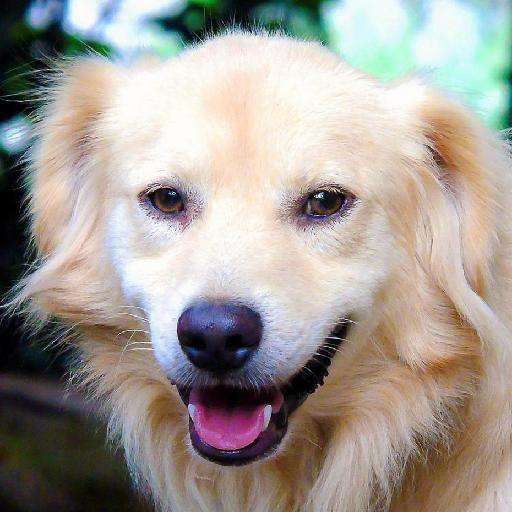

In [ ]:
index = 854+
img = ds["train"][index]["image"]
label = ds["train"][index]["label"]

print(label)
img


In [ ]:
from transformers import pipeline
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image

val_transforms = Compose([
    Resize(256),
    CenterCrop(224),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def transform_image(image):
    return val_transforms(image)



pipe = pipeline(
    task="image-classification",
    model="/home/tuchsanai/my_awesome_food_model",
    image_transform=transform_image,
    device=0 )



OSError: /home/tuchsanai/my_awesome_food_model does not appear to have a file named config.json. Checkout 'https://huggingface.co//home/tuchsanai/my_awesome_food_model/tree/None' for available files.

In [ ]:
pipe(img)

[{'label': 'dog', 'score': 0.5798318386077881},
 {'label': 'wild', 'score': 0.22988539934158325},
 {'label': 'cat', 'score': 0.19028279185295105}]